# Chapter 3. 분류

## 3.1. MNIST

In [3]:
# MNIST 데이터셋 내려받기
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:100: UserWarning: A network error occurred while downloading https://openml.org/api/v1/json/data/554. Retrying...
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- 사이킷런에서 읽어들인 데이터셋들은 일반적으로 비슷한 딕셔너리 구조를 가지고 있음.
  - 데이터셋을 설명하는 DESCR 키
  - 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
  - 레이블 배열을 담은 target 키

In [4]:
# 배열 살펴보기
X,y=mnist['data'], mnist['target']
X.shape

(70000, 784)

In [5]:
X, y = mnist.data, mnist.target
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

> - 이미지가 70,000개 있고 각 이미지에는 784개의 특성이 있음.(이미지가 28*28 픽셀)
- 개개의 특성: 0(흰색)~255(검은색)까지의 픽셀 강도

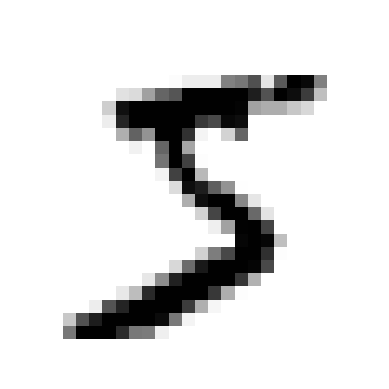

In [7]:
#이미지 하나 확인해보기
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#샘플의 특성 벡터를 추출하여 25*25 배열로 크기 바꾸기
some_digit = X[0]
some_digit_image=np.array(some_digit).reshape(28,28)

#맷플롯립의 imshow() 함수 사용해 그리기
plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")
plt.show()

In [8]:
# 그림 상으로는 숫자 5로 보임. 실제 레이블 확인
y[0]

'5'

In [9]:
# 레이블이 문자형 -> y를 정수로 변환
y=y.astype(np.uint8)

In [10]:
# test set을 만들고 따로 떼어놓기
X_train, X_test, y_train, y_test=X[:60000],X[60000:],y[:60000],y[60000:]

> 훈련 세트는 이미 섞여 있어서 모든 교차 검증 폴드를 비슷하게 만듦


## 3.2. 이진 분류기 훈련
#### 5-감지기
- '5'와 '5 아님' 두 개의 클래스를 구분

In [11]:
y_train_5=(y_train==5) # 5는 True고, 다른 숫자는 모두 False
y_test_5=(y_test==5)

- 분류 모델을 하나 선택해서 훈련시키자.
: SGDClassifier 클래스 사용해 "확률적 경사 하강법(SGD)" 분류기 사용
  - 매우 큰 데이터셋을 효율적으로 처리 가능

In [12]:
# SGDClassifier 모델을 만들고 전체 훈련 세트를 사용해 훈련시키기
from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
# 이 모델을 사용해 숫자 5의 이미지 감지
sgd_clf.predict([some_digit])

array([ True])

## 3.3. 성능 측정
### 3.3.1 교차 검증을 사용한 정확도 측정

In [14]:
#교차검증 구현
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# skfolds = StratifiedKFold(n_splits=3, random_state=42)
skfolds = StratifiedKFold(n_splits=3, random_state=None)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)  # sgd_clf 복제
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.95035
0.96035
0.9604


- cross_val_score()함수로 폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassifier 모델 평가
- k-겹 교차검증: 훈련 세트를 k개(3개)의 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

> 모든 교차 검증 폴드에 대해 정확도가 95% 이상


In [16]:
# 모든 이미지를 '5아님' 클래스로 분류하는 더미 분류기를 만들어 비교
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X),1), dtype=bool)

In [17]:
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

> - 정확도가 90% 이상으로 나옴
- 이미지의 10%정도만 숫자 5이기때문에 무조건 '5아님'으로 예측하면 정확히 맞출 확률이 90%
- 따라서, 정확도를 분류기의 성능 측정 지표로 선호하지 않음. 특히 불균형한 데이터셋을 다룰 때


### 3.3.2 오차 행렬

- 오차 행렬: 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것

- 오차 행렬을 만들기 위해 실제 타깃과 비교할 수 있도록 예측값을 만들어야 함

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [19]:
# confusion_matrix() 함수 사용해 오차 행렬 만들기
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

- 오차 행렬의 행: 실제 클래스
- 오차 행렬의 열: 예측한 클래스

In [20]:
y_train_perfect_predictions=y_train_5     # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

- 정밀도: 양성 예측의 정확도

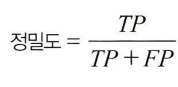

  - TP: 진짜 양성의 수
  - FP: 거짓 양성의 수

- 재현율: 분류기가 정확하게 감지한 양성 샘플의 비율(민감도, 진짜 양성 비율)

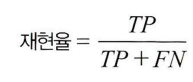

  - FNL 거짓 음성의 수

### 3.3.3 정밀도와 재현율

In [21]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # ==4096/(4096+1522)

0.8370879772350012

In [22]:
recall_score(y_train_5, y_train_pred)  #==4096/(4096+1325)

0.6511713705958311

- F1 Score: 정밀도와 재현율의 조화 평균
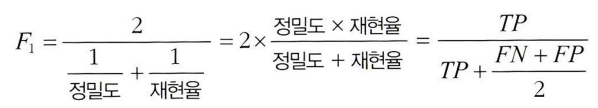


In [23]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

- f1 score가 높다고 해서 항상 바람직한 것은 아님
- 정밀도/재현율 트레이드오프 : 정밀도를 올리면 재현율이 줄고 그 반대도 마찬가지


### 3.3.4 정밀도/재현율 트레이드오프

In [24]:
# 예측에 사용한 점수 확인
y_scores=sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [25]:
threshold=0
y_some_digit_pred=(y_scores>threshold)

In [26]:
# SGDClassifier 임곗값이 0이므로 predict()메서드와 같은 결과를 반환.
# 임곗값 높여보자
threshold=8000
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([False])

> - 임곗값을 높이면 재현율이 줄어듦.
> - 그렇다면 적절한 임곗값 정하기?

In [27]:
y_scores=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                           method='decision_function')

In [28]:
# precision_recall_curve() 함수 사용해 모든 임곗값에 대해 정밀도와 재현율 계산 가능
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds=precision_recall_curve(y_train_5, y_scores)

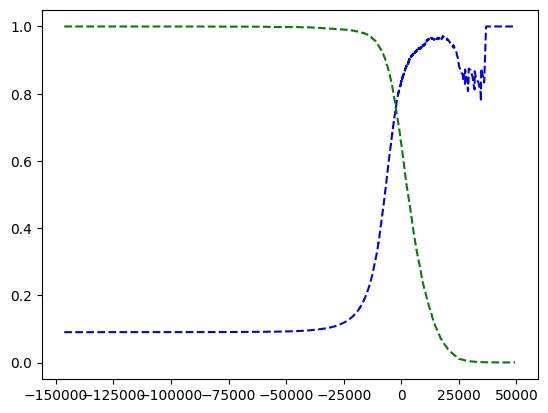

In [29]:
# matplotlib 이용해 임곗값의 함수로 정밀도와 재현율 그리기
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], 'b--', label='정밀도')
  plt.plot(thresholds, recalls[:-1], 'g--', label='재현율')
  #[...] # 임곗값을 표시하고 범례, 축이름, 그리드 추가

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

- 정밀도 곡선이 재현율 곡선보다 울퉁불퉁한 이유: 임곗값을 올리더라도 정밀도가 낮아질 때도 있기 때문
- 재현율 80% 근처에서 정밀도가 급격하게 감소: 이 하강점 직전을 정밀도/재현율 tradeoff로 선택하는 것이 좋음

In [30]:
threshold_90_precision=thresholds[np.argmax(precisions>=0.9)]

In [31]:
y_train_pred_90=(y_scores>=threshold_90_precision)

In [32]:
# 이 예측에 대한 정밀도와 재현율 확인
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [33]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

> - 정밀도 높은 분류기 만들기 : 충분히 큰 임곗값 지정
- 재현율이 너무 낮다면 높은 정밀도의 분류기는 유용하지 X


### 3.3.5 ROC 곡선
- 수신기 조작 특성(ROC) 곡선 : 이진 분류에서 널리 사용하는 도구
- 민감도(재현율)에 대한 1-특이도 그래프
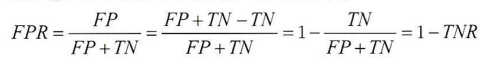

In [34]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds=roc_curve(y_train_5, y_scores)

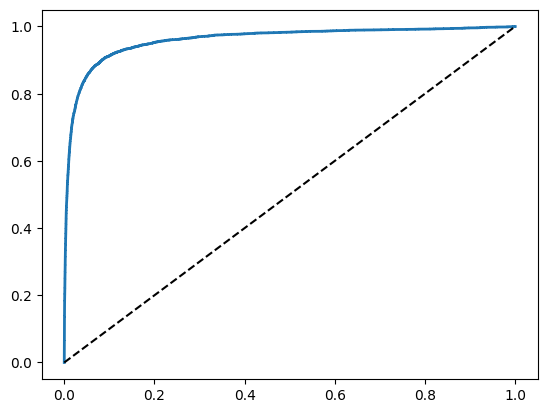

In [35]:
# TPR에 대한 FPR 곡선 그리기
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1],[0,1], 'k--') # 대각 점선

plot_roc_curve(fpr, tpr)
plt.show()

> - 여기서도 tradeoff가 있음
- 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어남
- 좋은 분류기는 ROC 점선에서 최대한 멀리 떨어져 있어야 함

- 곡선 아래의 면적(AUC)을 측정하면 분류기들 비교 가능
- 완벽한 분류기는 ROC의 AUC가 1, 완전한 랜덤 분류기는 0.5

In [36]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [37]:
from sklearn.ensemble import RandomForestClassifier

forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                  method='predict_proba')

In [40]:
y_scores_forest=y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest=roc_curve(y_train_5, y_scores_forest)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

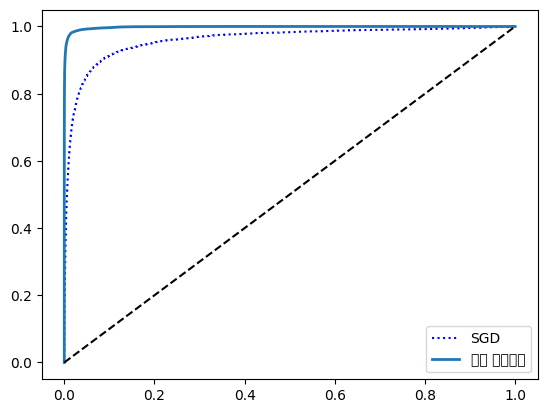

In [41]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, '랜덤 포레스트')
plt.legend(loc='lower right')
plt.show()

> - ROC 곡선 비교 : 랜덤 포레스트 분류기가 SGD 분류기보다 훨씬 좋음

- 랜포의 ROC 곡선이 왼쪽 위 모서리에 더 가까워 AUC 값이 크기 때문


In [42]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## 3.4 다중분류
- 다중 분류기 : 둘 이상의 클래스 구별
- OvR 전략: 이미지 분류 시 각 분류기의 결정 점수 중 가장 높은 것을 클래스로 선택
- OvO 전략: 각 숫자의 조합마다 이진 분류기를 훈련
  - 장점) 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요

In [43]:
# 서포트 벡터 머신 분류기 테스트
from sklearn.svm import SVC
svm_clf=SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [44]:
# decision_function() 이용해 샘플당 10개의 점수 반환
some_digit_scores=svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

> 가장 높은 점수는 클래스 5에 해당하는 값

In [45]:
np.argmax(some_digit_scores)

5

In [46]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [47]:
svm_clf.classes_[5]

5

In [48]:
# SVC 기반으로 OvR 전략 사용하는 다중분류기 생성
from sklearn.multiclass import OneVsRestClassifier
ovr_clf=OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [49]:
len(ovr_clf.estimators_)

10

In [50]:
# SGDClassifier 훈련
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

> - 분류기가 예측 결과에 강한 확신을 보이고 있음

In [51]:
# 분류기 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [52]:
# 입력 스케일 조정을 통해 정확도 89% 이상으로 높이기
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

## 3.5 에러 분석
- 여러 모델 시도 후 가장 좋은 몇 개를 골라 GridSearchCv를 사용해 하이퍼파라미터 튜닝
- 이 절에서는 가능성이 높은 모델을 하나 찾았다고 가정하고 이 모델의 성능 향상시킬 방법 찾자
  - 만들어진 에러의 종류를 분석

In [53]:
# 오차행렬 살펴보기
y_train_pred=cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx=confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

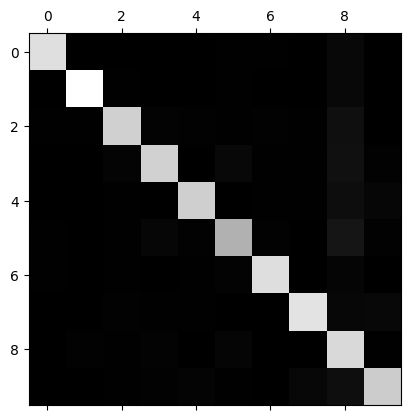

In [54]:
# 오차행렬을 이미지로 표현
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

> - 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있음
- 숫자 5는 다른 숫자보다 조금 더 어두움 : 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻

- 그래프의 에러 부분에 초점을 맞추자
- 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교

In [55]:
row_sums=conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx=conf_mx/row_sums

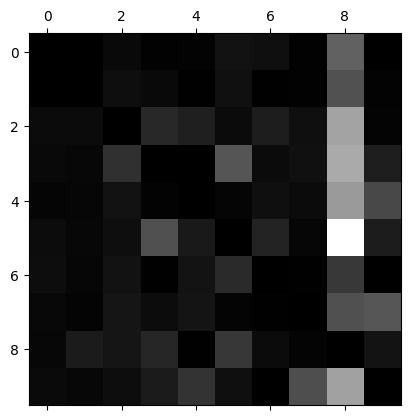

In [56]:
# 다른 항목은 그대로 유지하고 주대각선만 0으로 채워서 그래프 그리기
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

- 잘못 분류된 것을 줄이도록 개선?
  - 8처럼 보이는 숫자의 훈련 데이터를 더 많이 모아서 실제 8과 구분하도록 분류기를 학습 등

In [59]:
# 맷플롯립의 imshow() 사용하는 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

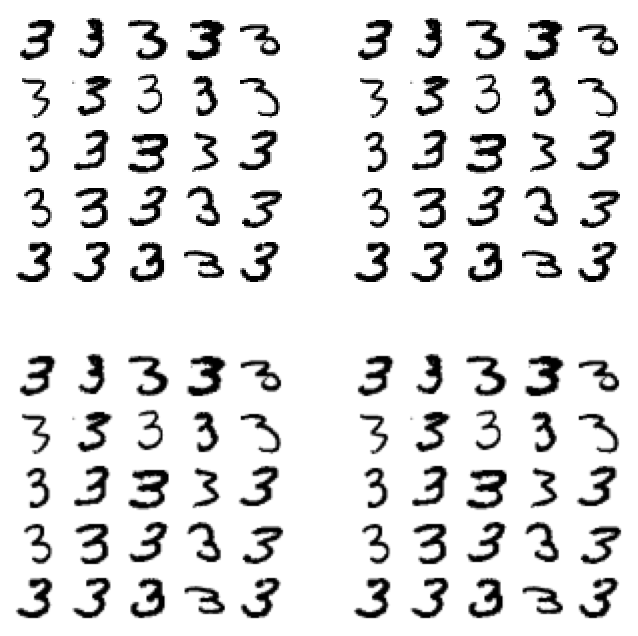

In [60]:
cl_a, cl_b=3,5
X_aa=X_train[(y_train==cl_a)&(y_train_pred==cl_a)]
X_ab=X_train[(y_train==cl_a)&(y_train_pred==cl_b)]
X_ba=X_train[(y_train==cl_b)&(y_train_pred==cl_a)]
X_bb=X_train[(y_train==cl_b)&(y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221);plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222);plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(223);plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(224);plot_digits(X_aa[:25], images_per_row=5)
plt.show()

- 잘못 분류된 이미지의 에러의 원인
  - 선형 모델인 SGDClassifier를 사용했기 때문
  - 선형 분류기는 클래스마다 픽셀에 가중치를 할당, 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스 점수로 계산

- 3과 5의 에러를 줄이는 방법
  - 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하기


## 3.6 다중 레이블 분류
- 다중 레이블 분류 시스템: 여러 개의 이진 꼬리표를 출력하는 분류 시스템

In [61]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large=(y_train>=7) # 숫자가 큰 값(7,8,9)인지
y_train_odd=(y_train%2==1) # 숫자가 홀수인지
y_multilabel=np.c_[y_train_large, y_train_odd]

knn_clf=KNeighborsClassifier() # 인스턴스 만들기
knn_clf.fit(X_train, y_multilabel) # 타깃 배열 사용하여 훈련시킴

KNeighborsClassifier()

In [62]:
knn_clf.predict([some_digit]) # 예측을 만들면 레이블이 두 개 출력됨

array([[False,  True]])

In [63]:
# 다중 레이블 분류기 평가
y_train_knn_pred=cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

- 지지도: 타깃 레이블에 속한 샘플 수를 가중치로 주는 것
  - average='weighted'


## 3.7 다중 출력 분류
- 다중 출력 분류: 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것

In [64]:
# MNIST에서 픽셀 강도에 잡음 추가
noise=np.random.randint(0,100, (len(X_train), 784))
X_train_mod=X_train+noise
noise=np.random.randint(0,100,(len(X_test),784))
X_test_mod=X_test+noise
y_train_mod=X_train
y_test_mod=X_test

In [66]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = plt.cm.binary,
               interpolation="nearest")
    plt.axis("off")

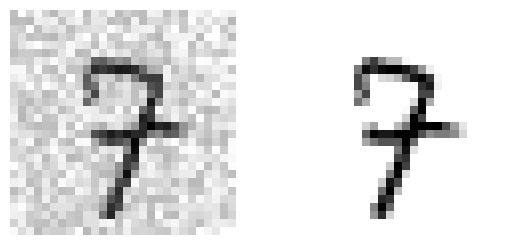

In [72]:
some_index1=1
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

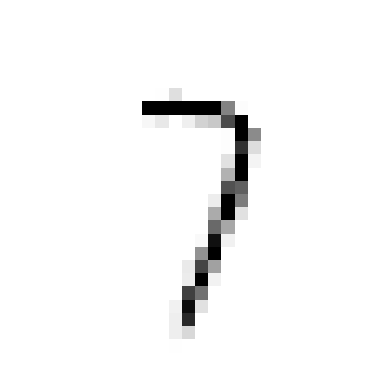

In [73]:
# 분류기를 훈련시켜 이미지 깨끗하게 만들기
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit=knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)